In [22]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

output = {}
seed = 1
np.random.seed(seed)

In [23]:
import numpy as np

class Activation():
    def __init__(self, activation_function, loss_function):
        self.activation_function = activation_function
        self.loss_function = loss_function
        self.cache = None

    def forward(self, Z):
        if self.activation_function == "sigmoid":
            A = np.where(Z >= 0, 1 / (1 + np.exp(-Z)), np.exp(Z) / (1 + np.exp(Z)))
            self.cache = Z
            return A

        elif self.activation_function == "relu":
            A = np.where(Z >= 0, Z, 0)
            self.cache = Z
            assert(A.shape == Z.shape)
            return A

        elif self.activation_function == "softmax":
            A = np.exp(Z - np.max(Z, axis=1, keepdims=True)) / np.sum(np.exp(Z - np.max(Z, axis=1, keepdims=True)), axis=1, keepdims=True)
            self.cache = Z
            return A

        elif self.activation_function == "linear":
            self.cache = Z.copy()
            return Z

        else:
            raise ValueError(f"Unsupported activation function: {self.activation_function}")


    def backward(self, dA=None, Y=None):
        if self.activation_function == "sigmoid":
            Z = self.cache
            dZ = dA * self.forward(Z) * (1 - self.forward(Z))
            assert (dZ.shape == Z.shape)
            return dZ

        elif self.activation_function == "relu":
            Z = self.cache
            dZ = np.where(Z > 0, dA, 0)
            assert (dZ.shape == Z.shape)
            return dZ

        elif self.activation_function == "softmax":
            Z = self.cache
            s = self.forward(Z)
            dZ = s - Y
            assert (dZ.shape == self.cache.shape)
            return dZ

        elif self.activation_function == "linear":
            return dA

        else:
            raise ValueError(f"Unsupported activation function: {self.activation_function}")

In [24]:
import numpy as np

class Dense():
    def __init__(self, n_x, n_y, seed=1):
        self.n_x = n_x
        self.n_y = n_y
        self.seed = seed
        self.initialize_parameters()

    def initialize_parameters(self):
        sd = np.sqrt(6.0 / (self.n_x + self.n_y))
        np.random.seed(self.seed)
        W = np.random.uniform(-sd, sd, (self.n_y, self.n_x)).T
        b = np.zeros((1, self.n_y))
        assert(W.shape == (self.n_x, self.n_y))
        assert(b.shape == (1, self.n_y))
        self.parameters = {"W": W, "b": b}

    def forward(self, A):
        Z = np.dot(A, self.parameters["W"]) + self.parameters["b"]
        self.cache = (A, self.parameters["W"], self.parameters["b"])
        assert(Z.shape == (A.shape[0], self.parameters["W"].shape[1]))
        return Z

    def backward(self, dZ):
        A_prev, W, b = self.cache
        m = A_prev.shape[0]
        self.dW = np.dot(A_prev.T, dZ) / m
        self.db = np.sum(dZ, axis=0, keepdims=True) / m
        dA_prev = np.dot(dZ, W.T)
        assert (dA_prev.shape == A_prev.shape)
        assert (self.dW.shape == self.parameters["W"].shape)
        assert (self.db.shape == self.parameters["b"].shape)
        return dA_prev

    def update(self, learning_rate):
        self.parameters["W"] = self.parameters["W"] - learning_rate * self.dW
        self.parameters["b"] = self.parameters["b"] - learning_rate * self.db


In [25]:
def predict(model, X, y=None):
    predictions = model.forward(X)
    if y is not None:
        mae = np.mean(np.abs(predictions - y))
        print("Mean Absolute Error:", mae)
    return predictions

In [26]:
def compute_MSE_loss(AL, Y):
    m = Y.shape[0]
    loss = (1/m) * np.sum(np.square(AL - Y))
    return loss

def compute_MAE_loss(AL, Y):
    m = Y.shape[0]
    loss = (1/m) * np.sum(np.abs(AL - Y))
    return loss

In [27]:
class Conv():
    def __init__(self, filter_size=2, input_channel=3, output_channel=8, pad=1, stride=1, seed=1):
        self.filter_size= filter_size
        self.input_channel=input_channel
        self.output_channel=output_channel
        self.seed = seed
        self.pad = pad
        self.stride = stride
        self.parameters = {'W':None, 'b': None}
        self.initialize_parameters()

    def initialize_parameters(self):
        np.random.seed(seed)
        sd = np.sqrt(6.0 / (self.input_channel + self.output_channel))
        W = np.random.uniform(-sd, sd, (self.filter_size,self.filter_size,self.input_channel,self.output_channel))
        b = np.zeros((1, 1, 1, self.output_channel))
        assert(W.shape == (self.filter_size,self.filter_size,self.input_channel,self.output_channel))
        assert(b.shape == (1,1,1,self.output_channel))
        self.parameters['W'] = W
        self.parameters['b'] = b

In [28]:
def zero_pad(X, pad):
    X_pad = np.zeros((X.shape[0], X.shape[1] + 2*pad, X.shape[2] + 2*pad, X.shape[3]))
    X_pad[:, pad:-pad, pad:-pad, :] = X
    return X_pad

In [29]:
def conv_single_step(self, a_slice_prev, W, b):
        sum = np.multiply(a_slice_prev, W)
        Z = np.sum(sum)
        Z = Z + float(b)
        return Z

Conv.conv_single_step = conv_single_step

In [30]:
def forward(self, A_prev):
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = self.parameters['W'].shape
    pad = self.pad
    stride = self.stride
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1
    Z = np.zeros((m, n_H, n_W, n_C))
    A_prev_pad = zero_pad(A_prev, pad)
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    a_slice_prev = A_prev_pad[i, vert_start:vert_end, horiz_start:horiz_end, :]
                    Z[i, h, w, c] = self.conv_single_step(a_slice_prev, self.parameters['W'][:,:,:,c], self.parameters['b'][:,:,:,c])
    assert(Z.shape == (m, n_H, n_W, n_C))
    self.cache = A_prev
    return Z

Conv.forward = forward

In [31]:
def backward(self, dZ):
    A_prev = self.cache
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = self.parameters['W'].shape
    (m, n_H, n_W, n_C) = dZ.shape
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))
    A_prev_pad = zero_pad(A_prev, pad=self.pad)
    dA_prev_pad = zero_pad(dA_prev, pad=self.pad)
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]

        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * self.stride
                    vert_end = vert_start + f
                    horiz_start = w * self.stride
                    horiz_end = horiz_start + f
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += self.parameters['W'][:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c] / m
                    db[:,:,:,c] += dZ[i, h, w, c] / m
        dA_prev[i, :, :, :] = da_prev_pad[self.pad:-self.pad, self.pad:-self.pad, :]
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    self.dW = dW
    self.db = db
    return dA_prev
Conv.backward = backward

In [32]:
def update(self, learning_rate):
    self.parameters["W"] = self.parameters["W"] - learning_rate * self.dW
    self.parameters["b"] = self.parameters["b"] - learning_rate * self.db
Conv.update = update

In [33]:
class MaxPool():
    def __init__(self, pool_size=2, stride=2):
        self.pool_size = pool_size
        self.stride = stride

    def create_mask_from_window(self, x):
        mask = x == np.max(x)
        return mask

In [34]:
def forward(self, A_prev):
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    n_H = int((n_H_prev - self.pool_size) / self.stride) + 1
    n_W = int((n_W_prev - self.pool_size) / self.stride) + 1
    n_C = n_C_prev
    A = np.zeros((m, n_H, n_W, n_C))

    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range (n_C):
                    vert_start = h * self.stride
                    vert_end = vert_start + self.pool_size
                    horiz_start = w * self.stride
                    horiz_end = horiz_start + self.pool_size
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    A[i, h, w, c] = np.max(a_prev_slice)
    self.cache = A_prev
    assert(A.shape == (m, n_H, n_W, n_C))
    return A

MaxPool.forward = forward

In [35]:
def backward(self, dA):
    A_prev = self.cache
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    dA_prev = np.zeros(A_prev.shape)
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range (n_C):
                    vert_start = h * self.stride
                    vert_end = vert_start + self.pool_size
                    horiz_start = w * self.stride
                    horiz_end = horiz_start + self.pool_size
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    mask = self.create_mask_from_window(a_prev_slice)
                    dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
    assert(dA_prev.shape == A_prev.shape)
    return dA_prev

MaxPool.backward = backward

In [36]:
class Flatten():
    def __init__(self):
        pass

In [37]:
def forward(self, A_prev):
    self.cache = A_prev.shape
    A = A_prev.reshape(A_prev.shape[0], -1)
    return A

Flatten.forward = forward

In [38]:
def backward(self, dA):
    dA_prev = dA.reshape(self.cache)
    return dA_prev

Flatten.backward = backward

In [39]:
class Model():
    def __init__(self):
        self.layers=[]

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, X):
        A = X
        for l in range(len(self.layers)):
            A = self.layers[l].forward(A)
        return A

    def backward(self, AL=None, Y=None):
        L = len(self.layers)
        epsilon = 1e-5
        dAL = -(np.divide(Y, AL+epsilon) - np.divide(1 - Y, 1 - AL+epsilon))
        dA_prev = self.layers[L-1].backward(dAL)
        for l in reversed(range(L-1)):
            dA_prev = self.layers[l].backward(dA_prev)
        return dA_prev

    def update(self, learning_rate):
        for l in range(len(self.layers)):
            if self.layers[l].__class__.__name__ == "Conv" or self.layers[l].__class__.__name__ == "Dense":
              self.layers[l].update(learning_rate)


讀取空氣品質資料，從csv改為npz

In [40]:
def AQI_calculator(O3, PM25, PM10, CO, SO2, NO2):
  table_of_AQI  = [0, 51, 101, 151, 201, 301, 401]
  table_of_O3  = [0, 55, 125, 165, 205, 405, 505]       #ppb
  table_of_PM25 = [0, 15.5, 35.5, 54.5, 150.5, 250.5, 350.5]  #ug/m3
  table_of_PM10 = [0, 51, 101, 255, 355, 425, 505]       #ug/m3
  table_of_CO  = [0, 4.5, 9.5, 12.5, 15.5, 30.5, 40.5]    #ppm
  table_of_SO2  = [0, 21, 76, 186, 305, 605, 805]       #ppb
  table_of_NO2  = [0, 31, 101, 361, 650, 1250, 1650]     #ppb

  #O3
  O3_AQI = 0
  PM25_AQI = 0
  PM10_AQI = 0
  CO_AQI = 0
  SO2_AQI = 0
  NO2_AQI = 0

  for i in range (6):
    if table_of_O3[i] <= O3 < table_of_O3[i+1]:
      O3_AQI = table_of_AQI[i] + (O3 - table_of_O3[i])*(table_of_AQI[i+1] - table_of_AQI[i])/(table_of_O3[i+1] - table_of_O3[i])

    if table_of_PM25[i] <= PM25 < table_of_PM25[i+1]:
      PM25_AQI = table_of_AQI[i] + (PM25 - table_of_PM25[i])*(table_of_AQI[i+1] - table_of_AQI[i])/(table_of_PM25[i+1] - table_of_PM25[i])

    if table_of_PM10[i] <= PM10 < table_of_PM10[i+1]:
      PM10_AQI = table_of_AQI[i] + (PM10 - table_of_PM10[i])*(table_of_AQI[i+1] - table_of_AQI[i])/(table_of_PM10[i+1] - table_of_PM10[i])

    if table_of_CO[i] <= CO < table_of_CO[i+1]:
      CO_AQI = table_of_AQI[i] + (CO - table_of_CO[i])*(table_of_AQI[i+1] - table_of_AQI[i])/(table_of_CO[i+1] - table_of_CO[i])

    if table_of_SO2[i] <= SO2 < table_of_SO2[i+1]:
      SO2_AQI = table_of_AQI[i] + (SO2 - table_of_SO2[i])*(table_of_AQI[i+1] - table_of_AQI[i])/(table_of_SO2[i+1] - table_of_SO2[i])

    if table_of_NO2[i] <= NO2 < table_of_NO2[i+1]:
      NO2_AQI = table_of_AQI[i] + (NO2 - table_of_NO2[i])*(table_of_AQI[i+1] - table_of_AQI[i])/(table_of_NO2[i+1] - table_of_NO2[i])

  AQI = max(O3_AQI, PM25_AQI, PM10_AQI, CO_AQI, SO2_AQI, NO2_AQI)
  return int(AQI)

In [41]:
np.set_printoptions(suppress = True,precision=4)
df = pd.read_csv('output.csv', sep=",")

# 取除最後 6 列外的所有列作為特徵
x = df.iloc[:, :-6].values
# 取最後 6 列作為標籤（預測目標）
y = df.iloc[:, -6:].values

# 儲存為 .npz 文件
np.savez('newdata.npz', X=x, y=y)

# 載入 .npz 文件
data = np.load('newdata.npz', allow_pickle=True)
# 查看文件中的所有鍵
print(data.keys())

# 載入後檢查數據
X_train = data['X']
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, 18, 1)
print("asdfyu")
print(X_train_reshaped.shape)
y_train = data['y']
y_train_reshaped = np.zeros((y_train.shape[0],1))
for i in range(y_train.shape[0]):
  y_train_reshaped[i,0] = AQI_calculator(y_train[i,0], y_train[i,1], y_train[i,2], y_train[i,3], y_train[i,4], y_train[i,5])

# 檢查前幾個 X 和 y 的值
print('First few X values:', X_train[:5])
print('First few y values:', y_train[:5])

# 顯示 X 和 y 資料的形狀
print(X_train.shape)  # 顯示 X 資料的形狀
print(y_train.shape)  # 顯示 y 資料的形狀


KeysView(NpzFile 'newdata.npz' with keys: X, y)
asdfyu
(52464, 1, 18, 1)
First few X values: [[15.4   1.81  0.34  0.06  0.3   8.2   8.4  38.9  71.   21.7   0.   72.9
   2.7   1.87 64.   66.    4.2   3.3 ]
 [15.4   1.81  0.32  0.06  0.    7.3   7.3  40.3  65.   22.6   0.   72.6
   2.7   1.87 64.   67.    3.9   3.  ]
 [15.3   1.81  0.34  0.06  0.    7.4   7.1  39.6  56.   17.1   0.   72.5
   2.4   1.87 60.   53.    3.6   2.8 ]
 [15.3   1.8   0.32  0.06  0.    7.2   7.   40.4  57.   16.2   0.   72.4
   2.5   1.86 65.   72.    3.7   2.8 ]
 [15.3   1.8   0.29  0.06  0.    5.9   5.9  41.5  55.   15.3   0.   73.5
   2.5   1.86 63.   64.    3.1   2.5 ]]
First few y values: [[40.3 19.7 35.5  0.4  2.7  7.3]
 [39.6 19.7 35.5  0.4  2.4  7.4]
 [40.4 19.7 35.5  0.4  2.5  7.2]
 [41.5 19.7 35.5  0.4  2.5  5.9]
 [40.2 19.7 35.5  0.4  2.4  6. ]]
(52464, 18)
(52464, 6)


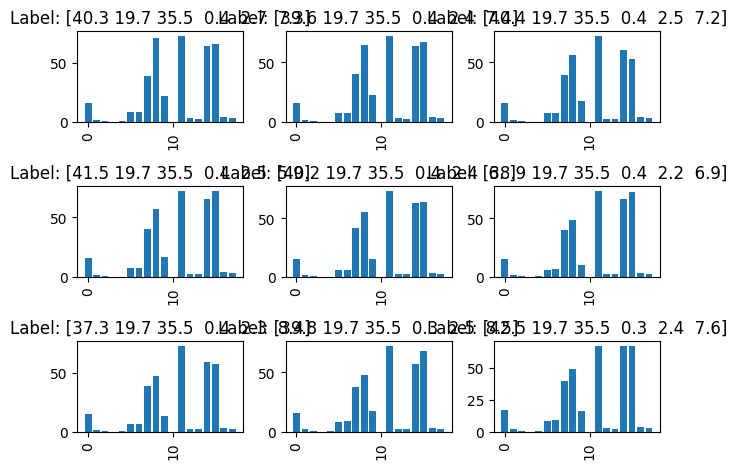

In [42]:
num_features = X_train.shape[1]

for i in range(9):
    plt.subplot(330 + 1 + i)

    # 將 X_loaded[i] 顯示為條形圖
    plt.bar(range(num_features), X_train[i])

    # 添加標題
    plt.title(f"Label: {y_train[i]}")
    plt.xticks(rotation=90)

# 顯示圖形
plt.tight_layout()
plt.show()

In [43]:
AQI_calculator(40.4, 8.1, 12.7, 0.2, 0.5, 6.8)

37

In [44]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    m = X.shape[0]
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:]
    shuffled_Y = Y[permutation,:]
    inc = mini_batch_size
    num_complete_minibatches = math.floor(m / mini_batch_size)

    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k*inc:(k+1)*inc,:]
        mini_batch_Y = shuffled_Y[k*inc:(k+1)*inc,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches*inc:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches*inc:,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)


    return mini_batches

In [ ]:
learning_rate = 0.0001
num_iterations = 1
batch_size = 64
costs = []

model = Model()
model.add(Conv(filter_size=3, input_channel=1, output_channel=16, pad=1, stride=2))
model.add(Activation("relu", None))
model.add(MaxPool(pool_size=2, stride=2))

model.add(Conv(filter_size=3, input_channel=16, output_channel=64, pad=1, stride=2))
model.add(Activation("relu", None))
model.add(MaxPool(pool_size=2, stride=2))

model.add(Flatten())

model.add(Dense(64, 1))
model.add(Activation("relu", None))




for i in range(0, num_iterations):
    print("epoch: ",i)
    mini_batches = random_mini_batches(X_train_reshaped, y_train_reshaped, batch_size)

    for batch in mini_batches:
        x_batch, y_batch = batch
        AL = model.forward(x_batch)
        cost = compute_MAE_loss(AL, y_batch)
        dA_prev = model.backward(AL=AL, Y=y_batch)
        model.update(learning_rate)

    print ("Cost after iteration %i: %f" %(i, cost))
    costs.append(cost)



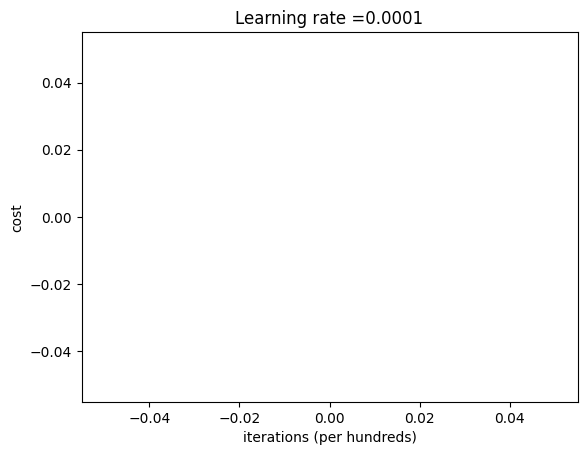

training------


NameError: name 'X_train_reshaped' is not defined

In [ ]:
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(learning_rate))
plt.show()

print('training------')
pred_train = predict(model, X_train_reshaped, y_train_reshaped)


In [ ]:
pred_test = predict(model, X_test)
df = pd.DataFrame({
    'ID': range(len(X_test)),
    'Label': pred_test.astype(int).flatten()
})
df.to_csv('CNN_AQI.csv', index=False, mode='w')

NameError: name 'X_test' is not defined